In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from scipy import stats
from scipy.optimize import minimize
import os


In [2]:
params = {
    'text.latex.preamble': '\\usepackage{gensymb} \\usepackage{amsmath}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

# Setup functions

### hBN $\epsilon$ and dispersion (Drude-Lorentz Model)

$\varepsilon (w) = \varepsilon_{\inf} (1 + \frac{\omega ^2_{LO} -  \omega ^2_{TO}}{\omega ^2_{TO} -\omega ^2 - iw\gamma } )$

_II means //

-L means _|_

Ab inition Calc. (Phys. Rev. B, 2001,63,115207)

Exp. ( Nat Commun 2014, 5 , 5221 ) and ( Solid State Commun. 2011, 141, 262 )

In [3]:
def epsilon_(w,e_inf_II,w_TO_II,gama_II,w_LO_II,e_inf_L,w_TO_L,gama_L,w_LO_L):
    
    Eps_II = e_inf_II*( 1 + (w_LO_II**2 - w_TO_II**2)/(w_TO_II**2 - w**2 - 1j*w*gama_II))
    
    Eps_L = e_inf_L*( 1 + (w_LO_L**2 - w_TO_L**2)/(w_TO_L**2 - w**2 - 1j*w*gama_L))
    
    return Eps_II,Eps_L

def dispersion_(ea,es,e_i,e_ii,d): #from Tunable Phonon Polaritons in Atomically Thin van der Waals...
    psi = np.sqrt(e_ii)/(1j*np.sqrt(e_i))
    
    return -(psi/d)*(np.arctan(ea/(e_i*psi)) + np.arctan(es/(e_i*psi)))

### Antenna geometries functions

Create array of vertices for this specific antenna

In [4]:
### Rod antenna ###

def create_vert(L,w):
    n_of_vertices = 4

    vert = np.zeros(n_of_vertices*2).reshape(n_of_vertices,2)

    vert[0,0] = -L/2
    vert[0,1] = -w/2

    vert[1,0] = L/2
    vert[1,1] = -w/2

    vert[2,0] = L/2
    vert[2,1] = w/2

    vert[3,0] = -L/2
    vert[3,1] = w/2
    
    return vert

Create vector which link the vertices

In [5]:
def create_path(vert):

    path = np.empty_like(vert)

    for i in range(len(vert)):
        if (i==len(vert)-1):
            path[i] = vert[0] - vert[i]
        else:
            path[i] = vert[i+1] - vert[i]
            
    return path

Create normalized vectors normal to the path vector

In [6]:
def create_normal(path):
    normal = np.empty_like(path)

    for i in range(len(path)):
        normal[i,0] = path [i,1]
        normal[i,1] = -path [i,0]
        normal[i] = normal[i]/np.linalg.norm(path[i])
    return normal

From the path vector, calculates the perimeter of antenna

In [7]:
def perimiter(path):
    d=0
    for i in range (len(path)):
        d = d + np.linalg.norm(path[i])
    return d

### Useful functions

Finds the index of vector corresponding to a given value

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [9]:
def find_nearest_2D(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Finds the lowest mesh size used in the simulation.

In [10]:
def path_resolution_(x,y):
    dx = np.zeros(len(x)-1)
    dy = np.zeros(len(y)-1)
    
    for i in range(len(x)-1):
        dx[i] = x[i+1]-x[i]
        
    for i in range(len(y)-1):
        dy[i] = y[i+1]-y[i]
        
    return np.min ( [np.min(dx),np.min(dy)])

### Generating coordinates and directions from geometry

Generates list with coordinates, direction of analysis and vertices positions given the vertices,path,normal, path resolution and the angle resolution (of analysis direction).

It first generates an array with ranging from zero to the perimiter and it calculates the its vertices. Than, for each position of this array, this coordinate is appended. Furthermore, if it is an vertice, it will generate a list of directions in which direction is given by vectors rotated between both normals of the sides of these vertices. If it is not a vertice, than it will simply save the normal vector of this side.

In [11]:
def gen_dir(v,p,n,path_res,ang_res):
    coor = []
    anal_dir = []
    vert_pos = [] #generate f(x)
    
    weg = np.arange(0,perimiter(p),path_res) #put all perimiter in an array with the desired resolution
    vert_mask = find_v_in_path(p,weg) # find the position of the vertices
    j=0
    point = v[0]        # set initial position and direction
    direc = p[0]/np.linalg.norm(p[0])
    
    for i in range(len(weg)):
        coor.append(point) #creates coordinates
        
        if(vert_mask[i]==1):
            vert_pos.append(i)
            if(j+1<(len(v))):
                last = (n[j])
                now = (n[j+1])
                j = j+1
            else:
                last = (n[-1])
                now = (n[0])
                
            l_a = angle_(last)
            n_a = angle_(now)
            
            #this creates the angles in which the initial direction will be rotated
            
            if (n_a-l_a>=0): #check if angle is being calculated in certain quadrants
                theta = np.arange(0,n_a-l_a,ang_res)
            else: #c
                theta = np.arange(0,2*np.pi-l_a+n_a,ang_res)
            rot_dir = []
            for t in range(len(theta)):
                vector = rotation_(last,theta[t])
                rot_dir.append(vector)               

            anal_dir.append(rot_dir)
        else:
            anal_dir.append(n[j])
        
        
        direc =  p[j]/np.linalg.norm(p[j])
        point = point + path_res*direc #goes to next point
        
    return coor,anal_dir, vert_pos

Find the vertices in the perimeter array

In [12]:
def find_v_in_path(p,caminho):
    result = np.zeros(len(caminho))
    d = 0
    for i in range(len(p)):
        d = d + np.linalg.norm(path[i])
        j = find_nearest(caminho,d)
        result[j] = 1
    return result

Calculates the angle of the vector considering its quadrant ( 0 -> $2\pi$ )

In [13]:
def angle_(v):
    x = v[0]
    y = v[1]
    
    if (x==0):
        return np.sign(y)*np.pi/2
    if (x>=0 and y >= 0):
        return np.arctan(y/x)
    if (x<0 and y>=0):
        return np.arctan(y/x) + np.pi
    if (x<0 and y<0):
        return np.arctan(y/x) + np.pi
    if (x>=0 and y<0):
        return np.arctan(y/x) + 2*np.pi

Rotates vector by $\phi$

In [14]:
def rotation_(v,phi):
    r = np.zeros(4).reshape(2,2)
    r[0,0] = np.cos(phi)
    r[0,1] = - np.sin(phi)
    r[1,0] = np.sin(phi)
    r[1,1] = np.cos(phi)
    
    return r @ v

### Extract profile from arbitrary direction (linear interpolation is used)

Check if the direction is parallel. If it is, then its easy.
If its not, than pick ups profiles along a desired path.

In [15]:
def extract_profile_v2(x,y,E,initial,dir_,path_res):
    
    # find closest initial point to desired
    
    ini_x = find_nearest(array=x,value=initial[0])
    ini_y = find_nearest(array=y,value=initial[1])
    
    # Take profiles for directions parallel to the grid
    
    # Horizontal direction
    
    if (dir_[1]==0):
        if(dir_[0]<0):
            profile_path_dist = (abs(x[:ini_x])-abs(x[ini_x]))
            idx = np.argsort(profile_path_dist)
            profile_path_dist = profile_path_dist[idx]
            profile = E[:ini_x,ini_y][idx]
            return profile_path_dist , profile
        if(dir_[0]>0):
            profile_path_dist = abs(x[ini_x:])-abs(x[ini_x])
            idx = np.argsort(profile_path_dist)
            profile = E[ini_x:,ini_y][idx]
            return profile_path_dist , profile
    
    # Vertical direction

    if (dir_[0]==0):
        if(dir_[1]<0):
            profile_path_dist = abs(y[:ini_y])-abs(y[ini_y])
            idx = np.argsort(profile_path_dist)
            profile_path_dist = profile_path_dist[idx]
            profile = E[ini_x,:ini_y][idx]
            return profile_path_dist , profile
        if(dir_[1]>0):
            profile_path_dist = abs(y[ini_y:])-abs(y[ini_y])
            idx = np.argsort(profile_path_dist)
            profile_path_dist = profile_path_dist[idx]
            profile = E[ini_x,ini_y:][idx]
            return profile_path_dist , profile
        
    # In the case that direction is not parallel to the grid
    signal_map = np.zeros(E.size).reshape(E.shape)
    
    profile_path_dist = []
    profile = []
    
    loc = [x[ini_x],y[ini_y]]
    dist = 0
    i = ini_x
    j = ini_y
    
    while( np.min(x) < loc[0] < np.max(x) and np.min(y) < loc[1] < np.max(y)):
        # Save this position and field
        profile_path_dist.append(dist)
        profile.append(E[i,j])
        
        #update signal map and indexes
        signal_map[i,j] = 1
        i_old = i
        j_old = j

        # Prepare next step
        while(signal_map[i,j] == 1 and ( np.min(x) < loc[0] < np.max(x) and np.min(y) < loc[1] < np.max(y))):
            loc = loc + dir_*path_res
            i = find_nearest(array=x,value=loc[0])
            j = find_nearest(array=y,value=loc[1])
            
        # Calculates distance of next step
        dist = np.hypot(x[i]-x[ini_x],y[j]-y[ini_y])
        
    profile_path_dist = np.array(profile_path_dist)
    profile = np.array(profile)
    
    return profile_path_dist , profile

### Fit function

Fitting function for the extracted Ez profile

In [16]:
def fit_(x,A,a,k,phi,B,k_2,phi_2,f):
    return A*np.exp(-a*(x))*np.sin(k*(x)+phi)/x**f + B*np.sin(k_2*x+phi_2)/np.sqrt(x)

# Radiation Pattern Functions

In [17]:
def params_border(x,y,coordinates,vert_position,path_res,Ez_r,beg_value):
    
    # Making new coordinates sweep (downsampling)
    coord_sweep = np.arange(0,len(coordinates),2)
    only_border = np.array([i for i in coord_sweep if i not in vert_position])
    coord_sweep_new = np.sort(np.concatenate((only_border,np.array(vert_position)), axis=None))
    coord_sweep_new = np.concatenate((coord_sweep_new, [(coord_sweep_new[0])]), axis = None)
    
    # Parameters
    
    param = []
    coor_an = []
    dir_an = []

    signal = np.zeros(x.size*y.size).reshape(x.size,y.size) # let the code skip checked coordinates from sides

    for i in coord_sweep_new:
        if i in only_border:
            x0 =coordinates[i][0]
            y0 = coordinates[i][1]
            ini = [find_nearest(x,x0),find_nearest(y,y0)]

            if (x0<=np.max(x) and y0<=np.max(y)): #Bounds to values only inside analysis region
                if(signal[ini[0],ini[1]]==0):
                    signal[ini[0],ini[1]] = 1
                    dir_ = directions[i]
                    a,b = extract_profile_v2(x,y,Ez_r,[x0,y0],dir_,path_res)
                    beg = find_nearest(array=a,value=beg_value)

                    try:
                        bounds_1 = ((-np.inf,kapa-0.001,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,0), (np.inf, kapa+0.001 ,np.inf,np.inf,np.inf,np.inf,np.inf,0.5))
                        popt,pcov = curve_fit(fit_,a[beg:],b[beg:],p0=[b[0],kapa,q,0,0.1,1,0,0.25],bounds = bounds_1)
                        if(abs(popt[0])>0.5):
                            param.append(popt)
                            coor_an.append([x0,y0])
                            dir_an.append(dir_)
                    except:
                        pass

        if i in vert_position:
            x0 =coordinates[i][0]
            y0 = coordinates[i][1]
            ini = [find_nearest(x,x0),find_nearest(y,y0)]
            for j in range(0,len(directions[i]),2):
                dir_ = directions[i][j]
                a,b = extract_profile_v2(x,y,Ez_r,[x0,y0],dir_,path_res)
                beg = find_nearest(array=a,value=beg_value)

                try:
                    bounds_1 = ((-np.inf,kapa-0.001,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,0), (np.inf, kapa+0.001 ,np.inf,np.inf,np.inf,np.inf,np.inf,0.5))
                    popt,pcov = curve_fit(fit_,a[beg:],b[beg:],p0=[b[0],kapa,q,0,0.1,1,0,0.25],bounds = bounds_1)
                    if(abs(popt[0])>0.5):
                        param.append(popt)
                        coor_an.append([x0,y0])
                        dir_an.append(dir_)


                except:
                    pass
                               
    # Filtering outliers using Z-function
    z_amp = np.abs(stats.zscore(abs(np.array(param)[:,0])))
    idx_amp = np.where(z_amp>3)[0]
    z_dec = np.abs(stats.zscore(abs(np.array(param)[:,1])))
    idx_dec = np.where(z_dec>3)[0]
    
    idx = np.union1d(idx_amp,idx_dec)

    for i in sorted(idx, reverse=True):
        del param[i]
        del coor_an[i]
        del dir_an[i]
                
    return param,coor_an,dir_an

In [18]:
def params_border_circular(x,y,coordinates,path_res,Ez_r,beg_value):
    
    # Making new coordinates sweep (downsampling)
    coord_sweep = np.arange(len(coordinates))
    coord_sweep = np.concatenate((coord_sweep, [(coord_sweep[0])]), axis = None)
    
    # Parameters
    
    param = []
    coor_an = []
    dir_an = []

    signal = np.zeros(x.size*y.size).reshape(x.size,y.size) # let the code skip checked coordinates from sides

    for i in coord_sweep:
        x0 =coordinates[i][0]
        y0 = coordinates[i][1]
        ini = [find_nearest(x,x0),find_nearest(y,y0)]

        if (x0<=np.max(x) and y0<=np.max(y)): #Bounds to values only inside analysis region
            if(signal[ini[0],ini[1]]==0):
                signal[ini[0],ini[1]] = 1
                dir_ = directions[i]
                a,b = extract_profile_v2(x,y,Ez_r,[x0,y0],dir_,path_res)
                beg = find_nearest(array=a,value=beg_value)

                try:
                    bounds_1 = ((-np.inf,kapa-0.001,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,0), (np.inf, kapa+0.001 ,np.inf,np.inf,np.inf,np.inf,np.inf,0.5))
                    popt,pcov = curve_fit(fit_,a[beg:],b[beg:],p0=[b[0],kapa,q,0,0.1,1,0,0.25],bounds = bounds_1)
                    if(abs(popt[0])>0.1):
                        param.append(popt)
                        coor_an.append([x0,y0])
                        dir_an.append(dir_)
                except:
                    pass
                               
    # Filtering outliers using Z-function
    z_amp = np.abs(stats.zscore(abs(np.array(param)[:,0])))
    idx_amp = np.where(z_amp>3)[0]
    z_dec = np.abs(stats.zscore(abs(np.array(param)[:,1])))
    idx_dec = np.where(z_dec>3)[0]
    
    idx = np.union1d(idx_amp,idx_dec)

    for i in sorted(idx, reverse=True):
        del param[i]
        del coor_an[i]
        del dir_an[i]
                
    return param,coor_an,dir_an

In [19]:
def prop_length(coor_an,param,detect_factor):
    # Use detect factor = 0.5 for now
    
    prop_l = []
    for i in range(len(coor_an)):
        if (abs(param[i][0])<=0.5 or abs(param[i][1])<=0.05): 
            prop_l.append(0)
        else:
            propagation = minimize(lambda x: prop_length_equation(x, abs(param[i][0]),abs(param[i][1]),param[i][-1],detect_factor), x0=0.001)
            #propagation = -np.log(detect_factor/abs(param[i][0]))/abs(param[i][1])
            #print(propagation.x[0])
            if (propagation.x[0]>=0):
                prop_l.append(propagation.x[0])
            else:
                prop_l.append(0)
                
    return prop_l

In [20]:
def prop_length_v2(coor_an,param,detect_factor):
    # Use detect factor = 0.5 for now
    
    prop_l = []
    for i in range(len(coor_an)):

        propagation = minimize(lambda x: prop_length_equation(x, abs(param[i][0]),abs(param[i][1]),param[i][-1],detect_factor), x0=0.0001)

        prop_l.append(propagation.x[0])

                
    return prop_l

In [23]:
def prop_length_equation(x,A,dec,f,detect_factor):
    return (detect_factor - A*np.exp(-x*dec)/x**f)**2

In [24]:
def plot_func_1(coordinates,coor_an,dir_an,prop_l,param,f,f_i,L,p):
    fig = plt.figure(dpi=150)
    ax =  fig.add_subplot(1, 1, 1)
    ax.set_aspect('equal')

    #plt.title("Dec., " + "$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")


    # Antenna Geometry
    plot_geo = plt.plot(np.array(coordinates)[:,0],np.array(coordinates)[:,1],color="black")

    # Propagation Length

    arrow_size = np.array(prop_l)
    plot_arrows = plt.quiver(np.array(coor_an)[:,0],np.array(coor_an)[:,1],arrow_size*np.array(dir_an)[:,0],arrow_size*np.array(dir_an)[:,1],color="gray",alpha=0.5,scale=1, scale_units='xy')
    plot_ref = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1]+ arrow_size*np.array(dir_an)[:,1], marker=".", color="white",alpha=0)


     # Checking if arrow will be too small    
    if(np.mean(prop_l[:])<1):
        factor = 1
    else:
        factor = np.mean(prop_l[:])

     #Decay    
    arrow_size = factor*np.array(param)[:,1]/(max(np.array(param)[:,1]))
    cor = np.array(param)[:,1]
    sc_dec = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="Blues", marker=".",label="decay",s=15)
    sc_plot = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    #Amp

    arrow_size = factor*abs(np.array(param)[:,0])/(2*max(np.array(param)[:,0]))
    cor = abs(np.array(param)[:,0])
    sc_amp = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="Reds", marker=".",label="amplitude")
    plot_amp = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    ax.set_xlabel("$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")



    divider = make_axes_locatable(ax)
    cax_dec = divider.append_axes("right", size="5%", pad=0.05)
    clb_dec = plt.colorbar(sc_dec, cax = cax_dec)


    cax_amp = divider.append_axes("top", size="5%",pad=0.05)
    clb_amp = plt.colorbar(sc_amp, cax = cax_amp, orientation = "horizontal")
    cax_amp.xaxis.set_ticks_position("top")
    

In [25]:
def plot_func2(coordinates,coor_an,dir_an,prop_l,param,f,f_i,L,p):
    fig = plt.figure(dpi=150)
    ax =  fig.add_subplot(1, 1, 1)
    ax.set_aspect('equal')

    #plt.title("Dec., " + "$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")


    # Antenna Geometry
    plot_geo = plt.plot(np.array(coordinates)[:,0],np.array(coordinates)[:,1],color="black")

    # Propagation Length

    arrow_size = np.array(prop_l)
    plot_arrows = plt.quiver(np.array(coor_an)[:,0],np.array(coor_an)[:,1],arrow_size*np.array(dir_an)[:,0],arrow_size*np.array(dir_an)[:,1],color="gray",alpha=0.5,scale=1, scale_units='xy')
    plot_ref = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1]+ arrow_size*np.array(dir_an)[:,1], marker=".", color="white",alpha=0)


     # Checking if arrow will be too small    
    if(np.mean(prop_l[:])<1):
        factor = 1
    else:
        factor = np.mean(prop_l[:])

     #f factor (geometrical decay)   
    arrow_size = factor*np.array(param)[:,-1]/(max(np.array(param)[:,-1]))
    cor = np.array(param)[:,-1]
    sc_dec = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="Greens", marker=".",label="f",s=15)
    sc_plot = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    #Decay

    arrow_size = factor*abs(np.array(param)[:,1])/(2*max(np.array(param)[:,1]))
    cor = abs(np.array(param)[:,1])
    sc_amp = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="Blues", marker=".",label="amplitude")
    plot_amp = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    ax.set_xlabel("$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")



    divider = make_axes_locatable(ax)
    cax_dec = divider.append_axes("right", size="5%", pad=0.05)
    clb_dec = plt.colorbar(sc_dec, cax = cax_dec)


    cax_amp = divider.append_axes("top", size="5%",pad=0.05)
    clb_amp = plt.colorbar(sc_amp, cax = cax_amp, orientation = "horizontal")
    cax_amp.xaxis.set_ticks_position("top")
    

In [26]:
def plot_func3(coordinates,coor_an,dir_an,prop_l,param,f,f_i,L,p):
    fig = plt.figure(dpi=150)
    ax =  fig.add_subplot(1, 1, 1)
    ax.set_aspect('equal')
    

    #plt.title("Dec., " + "$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")


    # Antenna Geometry
    plot_geo = plt.plot(np.array(coordinates)[:,0],np.array(coordinates)[:,1],color="black")

    # Propagation Length

    arrow_size = np.array(prop_l)
    plot_arrows = plt.quiver(np.array(coor_an)[:,0],np.array(coor_an)[:,1],arrow_size*np.array(dir_an)[:,0],arrow_size*np.array(dir_an)[:,1],color="gray",alpha=0.5,scale=1, scale_units='xy')
    plot_ref = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1]+ arrow_size*np.array(dir_an)[:,1], marker=".", color="white",alpha=0)


     # Checking if arrow will be too small    
    if(np.mean(prop_l[:])<1):
        factor = 1
    else:
        factor = np.mean(prop_l[:])

     #f geometric decay factor 
    
    arrow_size = factor*np.array(param)[:,-1]/(max(np.array(param)[:,-1]))
    cor = np.array(param)[:,-1]
    sc_dec = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="Greens", marker=".",label="decay",s=15,vmin=0,vmax=0.5)
    sc_plot = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    #Amp
    
    amp_suave = np.convolve(abs(np.array(param)[:,0]), np.ones((3,))/3, mode='same')

    arrow_size = factor*abs(amp_suave)/(2*max(amp_suave))
    cor = amp_suave
    sc_amp = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="Reds", marker=".",label="amplitude")
    plot_amp = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    ax.set_xlabel("$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")



    divider = make_axes_locatable(ax)
    cax_dec = divider.append_axes("right", size="5%", pad=0.05)
    clb_dec = plt.colorbar(sc_dec, cax = cax_dec)


    cax_amp = divider.append_axes("top", size="5%",pad=0.05)
    clb_amp = plt.colorbar(sc_amp, cax = cax_amp, orientation = "horizontal")
    cax_amp.xaxis.set_ticks_position("top")
    

In [27]:
def plot_func5(coordinates,coor_an,dir_an,prop_l,param,f,f_i,L,p,Avmin,Avmax):
    fig = plt.figure(dpi=150)
    ax =  fig.add_subplot(1, 1, 1)
    ax.set_aspect('equal')
    

    #plt.title("Dec., " + "$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")


    # Antenna Geometry
    plot_geo = plt.plot(np.array(coordinates)[:,0],np.array(coordinates)[:,1],color="black",linewidth=1,alpha=0.5)

    # Propagation Length

    arrow_size = np.array(prop_l)
    plot_arrows = plt.quiver(np.array(coor_an)[:,0],np.array(coor_an)[:,1],arrow_size*np.array(dir_an)[:,0],arrow_size*np.array(dir_an)[:,1],color="gray",alpha=0.5,scale=1, scale_units='xy')
    plot_ref = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1]+ arrow_size*np.array(dir_an)[:,1], marker=".", color="white",alpha=0)


     # Checking if arrow will be too small    
    if(np.mean(prop_l[:])<1):
        factor = 1
    else:
        factor = np.mean(prop_l[:])

     #f geometric decay factor 
    f_suave = np.convolve(np.array(param)[:,-1], np.ones((5,))/5, mode='same')
    
    arrow_size = 0
    cor = f_suave
    sc_dec = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="seismic", marker=".",label="decay",s=15,vmin=0,vmax=0.5)
    #sc_plot = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    #Amp
    
    arrow_size = factor*abs(np.array(param)[:,0])/(2*max(np.array(param)[:,0]))
    cor = abs(np.array(param)[:,0])
    sc_amp = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="afmhot_r", marker=".",label="amplitude",vmin = Avmin, vmax = Avmax)
    #plot_amp = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    ax.set_xlabel("$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")



    divider = make_axes_locatable(ax)
    cax_dec = divider.append_axes("right", size="5%", pad=0.05)
    clb_dec = plt.colorbar(sc_dec, cax = cax_dec)


    cax_amp = divider.append_axes("top", size="5%",pad=0.05)
    clb_amp = plt.colorbar(sc_amp, cax = cax_amp, orientation = "horizontal")
    cax_amp.xaxis.set_ticks_position("top")
    

In [28]:
def plot_func4(coordinates,coor_an,dir_an,prop_l,param,f,f_i,L,p):
    fig = plt.figure(dpi=150)
    ax =  fig.add_subplot(1, 1, 1)
    ax.set_aspect('equal')

    #plt.title("Dec., " + "$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")


    # Antenna Geometry
    plot_geo = plt.plot(np.array(coordinates)[:,0],np.array(coordinates)[:,1],color="black")

    # Propagation Length

    arrow_size = np.array(prop_l)
    plot_arrows = plt.quiver(np.array(coor_an)[:,0],np.array(coor_an)[:,1],arrow_size*np.array(dir_an)[:,0],arrow_size*np.array(dir_an)[:,1],color="gray",alpha=0.5,scale=1, scale_units='xy')
    plot_ref = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1]+ arrow_size*np.array(dir_an)[:,1], marker=".", color="white",alpha=0)


     # Checking if arrow will be too small    
    if(np.mean(prop_l[:])<1):
        factor = 1
    else:
        factor = np.mean(prop_l[:])

     #f geometric decay factor
    
    arrow_size = factor/20
    cor = np.array(param)[:,-1]
    sc_dec = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="Greens", marker=".",label="decay",s=15)
    #sc_plot = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    #Amp

    arrow_size = 2*factor/20
    cor = abs(np.array(param)[:,0])
    sc_amp = plt.scatter(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],c = cor, cmap="Reds", marker=".",label="amplitude")
    #plot_amp = plt.plot(np.array(coor_an)[:,0] + arrow_size*np.array(dir_an)[:,0] ,np.array(coor_an)[:,1] + arrow_size*np.array(dir_an)[:,1],"--",color="black",alpha=0.5,linewidth=0.5)

    ax.set_xlabel("$\omega$ = "+ str(round(f[f_i])) + " cm$^{-1}$ , L = " + str(round(L[p],2)) + " $\mu m$")



    divider = make_axes_locatable(ax)
    cax_dec = divider.append_axes("right", size="5%", pad=0.05)
    clb_dec = plt.colorbar(sc_dec, cax = cax_dec)


    cax_amp = divider.append_axes("top", size="5%",pad=0.05)
    clb_amp = plt.colorbar(sc_amp, cax = cax_amp, orientation = "horizontal")
    cax_amp.xaxis.set_ticks_position("top")
    

In [29]:
def suav_mov_avarge(param, coor_an , dir_an,N,mode_):
    new_param = []
    new_coor_an = []
    new_dir_an = []
    
    for i in range(np.array(param).shape[1]):
        if (i==0):
            new_param.append(np.convolve(abs(np.array(param)[:,i]), np.ones((N,))/N, mode=mode_))
        else:
            new_param.append(np.convolve((np.array(param)[:,i]), np.ones((N,))/N, mode=mode_))
   
    new_coor_an.append(np.convolve((np.array(coor_an)[:,0]), np.ones((N,))/N, mode=mode_))
    new_coor_an.append(np.convolve((np.array(coor_an)[:,1]), np.ones((N,))/N, mode=mode_))

    new_dir_an.append(np.convolve((np.array(dir_an)[:,0]), np.ones((N,))/N, mode=mode_))
    new_dir_an.append(np.convolve((np.array(dir_an)[:,1]), np.ones((N,))/N, mode=mode_))
    
    return np.array(new_param).T,np.array(new_coor_an).T,np.array(new_dir_an).T
        

In [30]:
def find_nearest_2D(array, value):
    array = np.array(coordinates)
    dist_ = (array-value)[:,0]**2 + (array-value)[:,1]**2
    idx = dist_.argmin()
    return idx

In [31]:
def fresnel_N(L,lamb,dist):
    return L**2/(lamb*dist)

## Defining antenna and slab thickness

In [32]:
L = np.linspace(1,5,41)
width = 0.3 # in um
t = 0.05 # thickness of slab
Area = L*width #for rod antena

## Defining hBN drude-Lorentz parameters

In [33]:
e_inf_II = 2.95
w_TO_II = 780
gama_II = 4
w_LO_II = 830

e_inf_L = 4.87
w_TO_L = 1370
gama_L = 5
w_LO_L = 1610

## Opening data and saving a quadrant

In [34]:
folder = os.path.join('..', 'examples of data')+"\\"

x = np.loadtxt(folder+"x.txt")*10**6
y = np.loadtxt(folder+"y.txt")*10**6
f = np.loadtxt(folder+"f.txt")

f = f*10**-12*33.35641 #in cm1

## Chosing frequency window

In [35]:
wlo = 1250
wto = 1750

ini_f = find_nearest(f,wlo)
fim_f = find_nearest(f,wto)

f_b = f[ini_f:fim_f] #get five frequencies the band


### Creating field arrays

In [36]:
Ez_r = np.zeros(len(x)*len(y)).reshape(len(x),len(y))

### Chosing angular resolution of vertices

In [37]:
ang_res = 2*np.pi/180 # angular res

### Chosing detactable value of intensity

In [38]:
detect_factor = 0.5

### Testing for a single frequency and geometric variable

In [41]:
f_i

45

In [42]:
f_i = find_nearest(f,1480)
p = find_nearest(L,1)

Ez_r[:,:] = np.genfromtxt(folder+"Ez_L"+str(p+1)+"_r_f"+str(f_i+1)+".txt",max_rows=x.size,usecols=np.arange(0,y.size,1))

In [43]:
%%time
res = path_resolution_(x,y)/2 # um
ang_res = 1*np.pi/180 # angular res


max_position = np.zeros(2).reshape(2)
max_direction = np.zeros(2).reshape(2)


beg_value = 0.5 #beggining of fit

e_ii , e_i = epsilon_(f[f_i],e_inf_II,w_TO_II,gama_II,w_LO_II,e_inf_L,w_TO_L,gama_L,w_LO_L)
q = dispersion_(1.889,1,e_i,e_ii,t).real
kapa = dispersion_(1.889,1,e_i,e_ii,t).imag


    
vert = create_vert(L[p],width)
path = create_path(vert)
normal = create_normal(path)
path_res=path_resolution_(x,y) # um

coordinates,directions,vert_position = gen_dir(vert,path,normal,path_res,ang_res)

CPU times: total: 0 ns
Wall time: 3.91 ms


## Choose Direction for one fit

In [45]:
max_coord = find_nearest_2D(array = np.array(coordinates)[:,:] , value = [-L[p]/2,-width/2])

In [46]:
%%time
x0 =coordinates[max_coord][0]
y0 = coordinates[max_coord][1]
dir_ = directions[max_coord]

max_position = [x0,y0]
max_direction = dir_

#max_position = [0,0]

dir_= np.array([0,-1])

a,b = extract_profile_v2(x,y,Ez_r,max_position,dir_,path_res)

beg = find_nearest(array=a,value=beg_value)


try:
    popt,pcov = curve_fit(fit_,a[beg:],b[beg:],p0=[1,kapa,q,0,0.1,1,0,0.5])
    p_sigma = np.sqrt(abs(np.diag(pcov)))
    
    xdata = np.array(a[beg:])
    ydata = np.array(b[beg:])
    residuals = ydata- fit_(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)

    if (abs((popt[0]))>=p_sigma[0]):
        amp = abs((popt[0]))
        amp_error =p_sigma[0]
    if (abs((popt[1]))>=p_sigma[1]):
        decay=(popt[1])
        decay_error=(p_sigma[1])
except:
    pass

print(r_squared)

0.9953680612971576
CPU times: total: 15.6 ms
Wall time: 26.2 ms


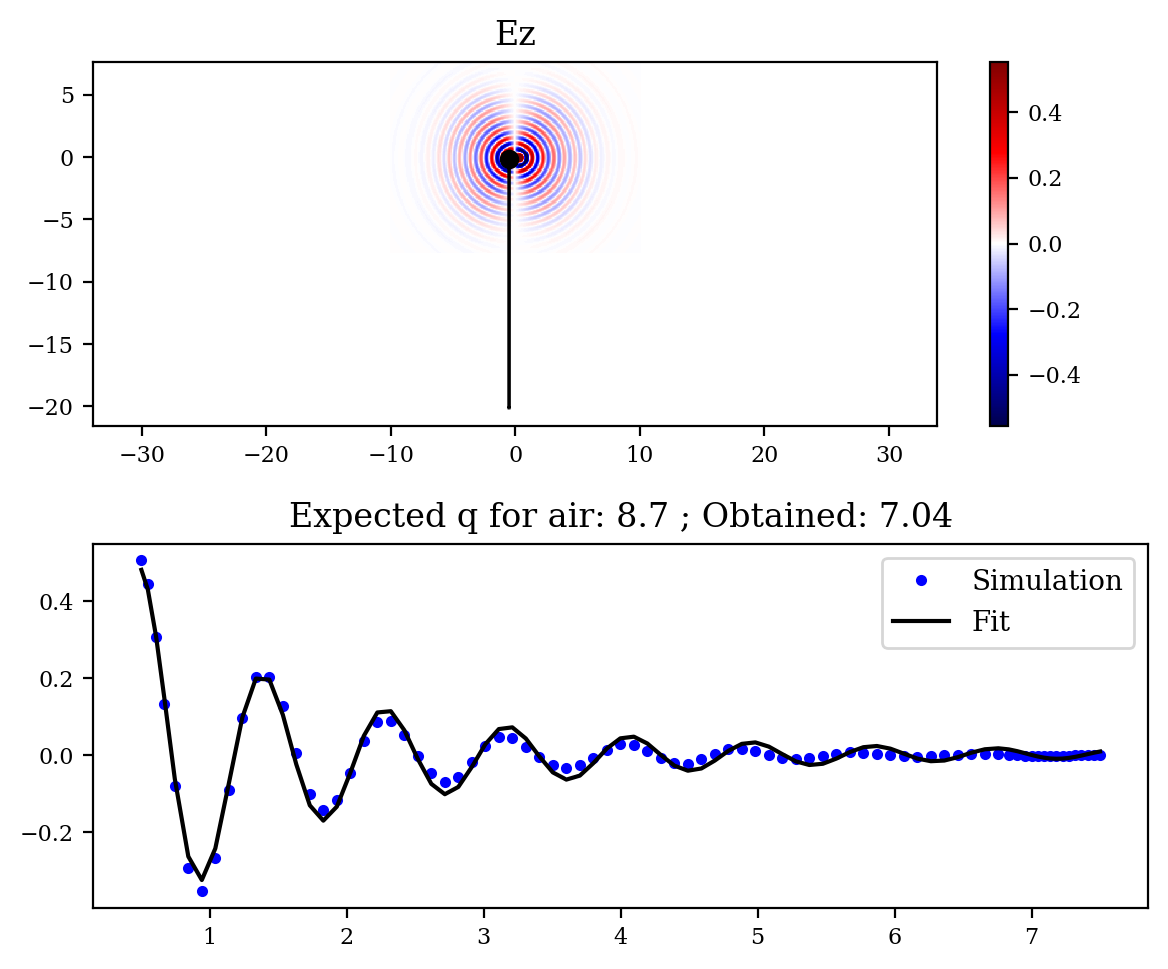

[-4.22370356e-01  3.51431504e-01  7.04093549e+00  1.16893866e+00
 -1.14572271e+00  2.92219530e-03  3.12840769e+00  5.00000000e-01]


In [47]:
X, Y = np.meshgrid(x,y)
plt.figure(figsize=(6,5),dpi=100)

arrow_size =20
plt.subplot(2,1,1)
plt.axis("equal")
plt.pcolor(X,Y,Ez_r.T,cmap="seismic",vmin=-np.max(b),vmax=np.max(b))
plt.colorbar()
plt.scatter(x0,y0,color="black",edgecolors="black")
plt.arrow(x0,y0,arrow_size*dir_[0],arrow_size*dir_[1],color="black")
plt.title("Ez")

bounds_1 = ((-np.inf,kapa-0.001,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,0), (np.inf, kapa+0.001 ,np.inf,np.inf,np.inf,np.inf,np.inf,0.5))

plt.subplot(2,1,2)
plt.plot(a[beg:],b[beg:],'b.',label="Simulation")
popt,pcov = curve_fit(fit_,a[beg:],b[beg:],p0=[1,kapa,q,0,0.1,1,0,0.5],bounds = bounds_1)

p_sigma = np.sqrt(abs(np.diag(pcov)))


plt.plot(a[beg:],fit_(a[beg:],*popt),'k-',label="Fit")
plt.title("Expected q for air: " +str(round(q,2)) +" ; Obtained: " + str(round(popt[2],2)))
plt.legend()
plt.tight_layout()
plt.show()
print(popt)

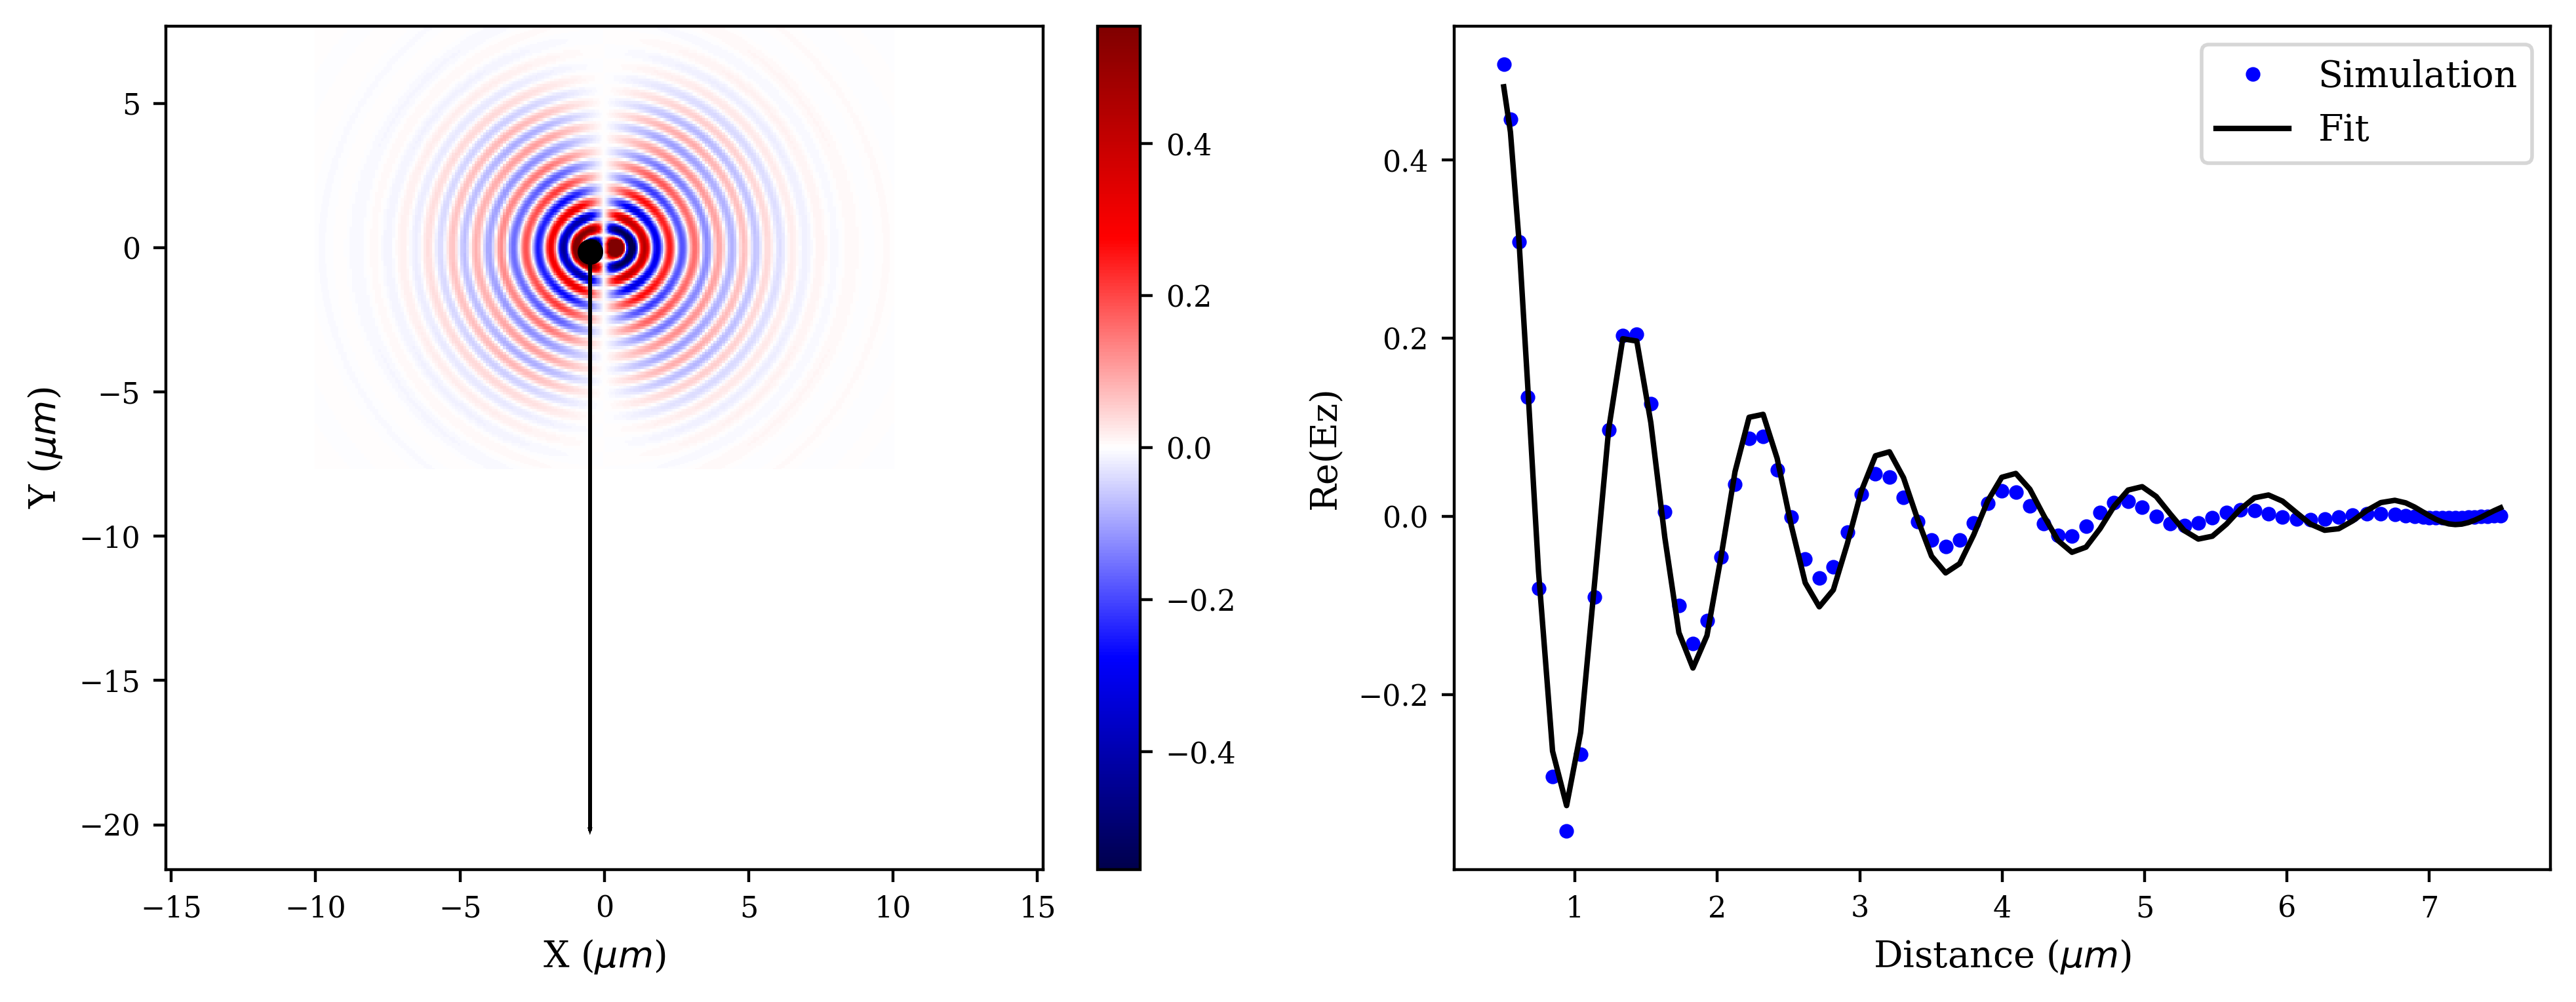

[-4.22370356e-01  3.51431504e-01  7.04093549e+00  1.16893866e+00
 -1.14572271e+00  2.92219530e-03  3.12840769e+00  5.00000000e-01]


In [48]:
X, Y = np.meshgrid(x,y)
plt.figure(figsize=(10,4),dpi=200)

arrow_size =20
plt.subplot(1,2,1)
plt.axis("equal")
plt.pcolor(X,Y,Ez_r.T,cmap="seismic",vmin=-np.max(b),vmax=np.max(b))
plt.colorbar()
plt.scatter(x0,y0,color="black",edgecolors="black")
plt.arrow(x0,y0,arrow_size*dir_[0],arrow_size*dir_[1],color="black")
plt.xlabel("X ($\mu m$)")
plt.ylabel("Y ($\mu m$)")

#plt.title("Ez")

bounds_1 = ((-np.inf,kapa-0.001,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,0), (np.inf, kapa+0.001 ,np.inf,np.inf,np.inf,np.inf,np.inf,0.5))

plt.subplot(1,2,2)
plt.plot(a[beg:],b[beg:],'b.',label="Simulation")
popt,pcov = curve_fit(fit_,a[beg:],b[beg:],p0=[1,kapa,q,0,0.1,1,0,0.5],bounds = bounds_1)

p_sigma = np.sqrt(abs(np.diag(pcov)))


plt.plot(a[beg:],fit_(a[beg:],*popt),'k-',label="Fit")
plt.xlabel("Distance ($\mu m$)")
plt.ylabel("Re(Ez)")

#plt.title("Expected q for air: " +str(round(q,2)) +" ; Obtained: " + str(round(popt[2],2)))
plt.legend()
plt.tight_layout()
plt.show()
print(popt)

# Calculate and plot for all directions

In [49]:
%%time
beg_value = 0.5 #beggining of fit

directions = []
for v in coordinates:
    directions.append(v/np.linalg.norm(v))

param, coor_an , dir_an= params_border_circular(x,y,coordinates,path_res,Ez_r,beg_value)

CPU times: total: 250 ms
Wall time: 1.54 s


In [50]:
### Calculating Propagation Length ##

detect_factor = 0.5
prop_l = prop_length_v2(coor_an,param,detect_factor)

C:\Users\rafae\AppData\Local\Temp\ipykernel_21232\2789250926.py:2: RuntimeWarning: invalid value encountered in power
  return (detect_factor - A*np.exp(-x*dec)/x**f)**2
C:\Users\rafae\AppData\Local\Temp\ipykernel_21232\2789250926.py:2: RuntimeWarning: overflow encountered in exp
  return (detect_factor - A*np.exp(-x*dec)/x**f)**2
C:\Users\rafae\AppData\Local\Temp\ipykernel_21232\2789250926.py:2: RuntimeWarning: invalid value encountered in power
  return (detect_factor - A*np.exp(-x*dec)/x**f)**2
C:\Users\rafae\AppData\Local\Temp\ipykernel_21232\2789250926.py:2: RuntimeWarning: invalid value encountered in power
  return (detect_factor - A*np.exp(-x*dec)/x**f)**2


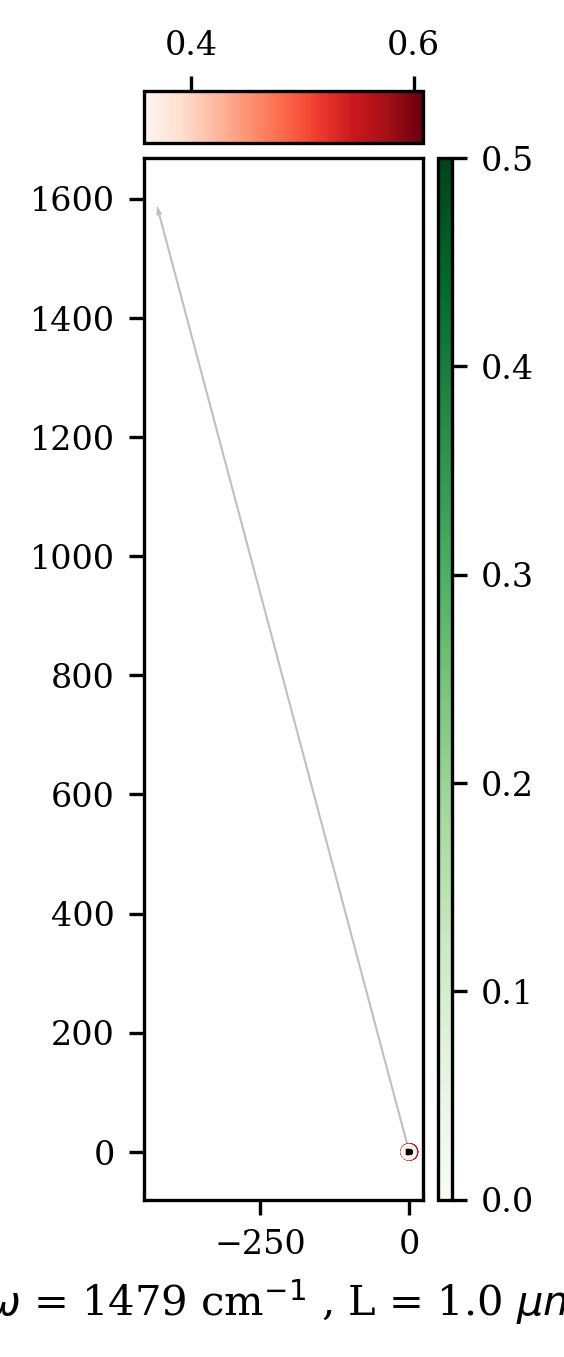

In [51]:
# Constructing and saving image ##################

plot_func3(coordinates,coor_an,dir_an,prop_l,param,f,f_i,L,p)
#plt.savefig("Test.png", bbox_inches='tight',dpi=200)
plt.show()

In [52]:
param2 , coor_an2 , dir_an2  = suav_mov_avarge(np.array(param),np.array(coor_an) , np.array(dir_an),3,"valid")

In [53]:
### Calculating Propagation Length ##

detect_factor = 0.5
prop_l2 = prop_length_v2(coor_an2,param2,detect_factor)

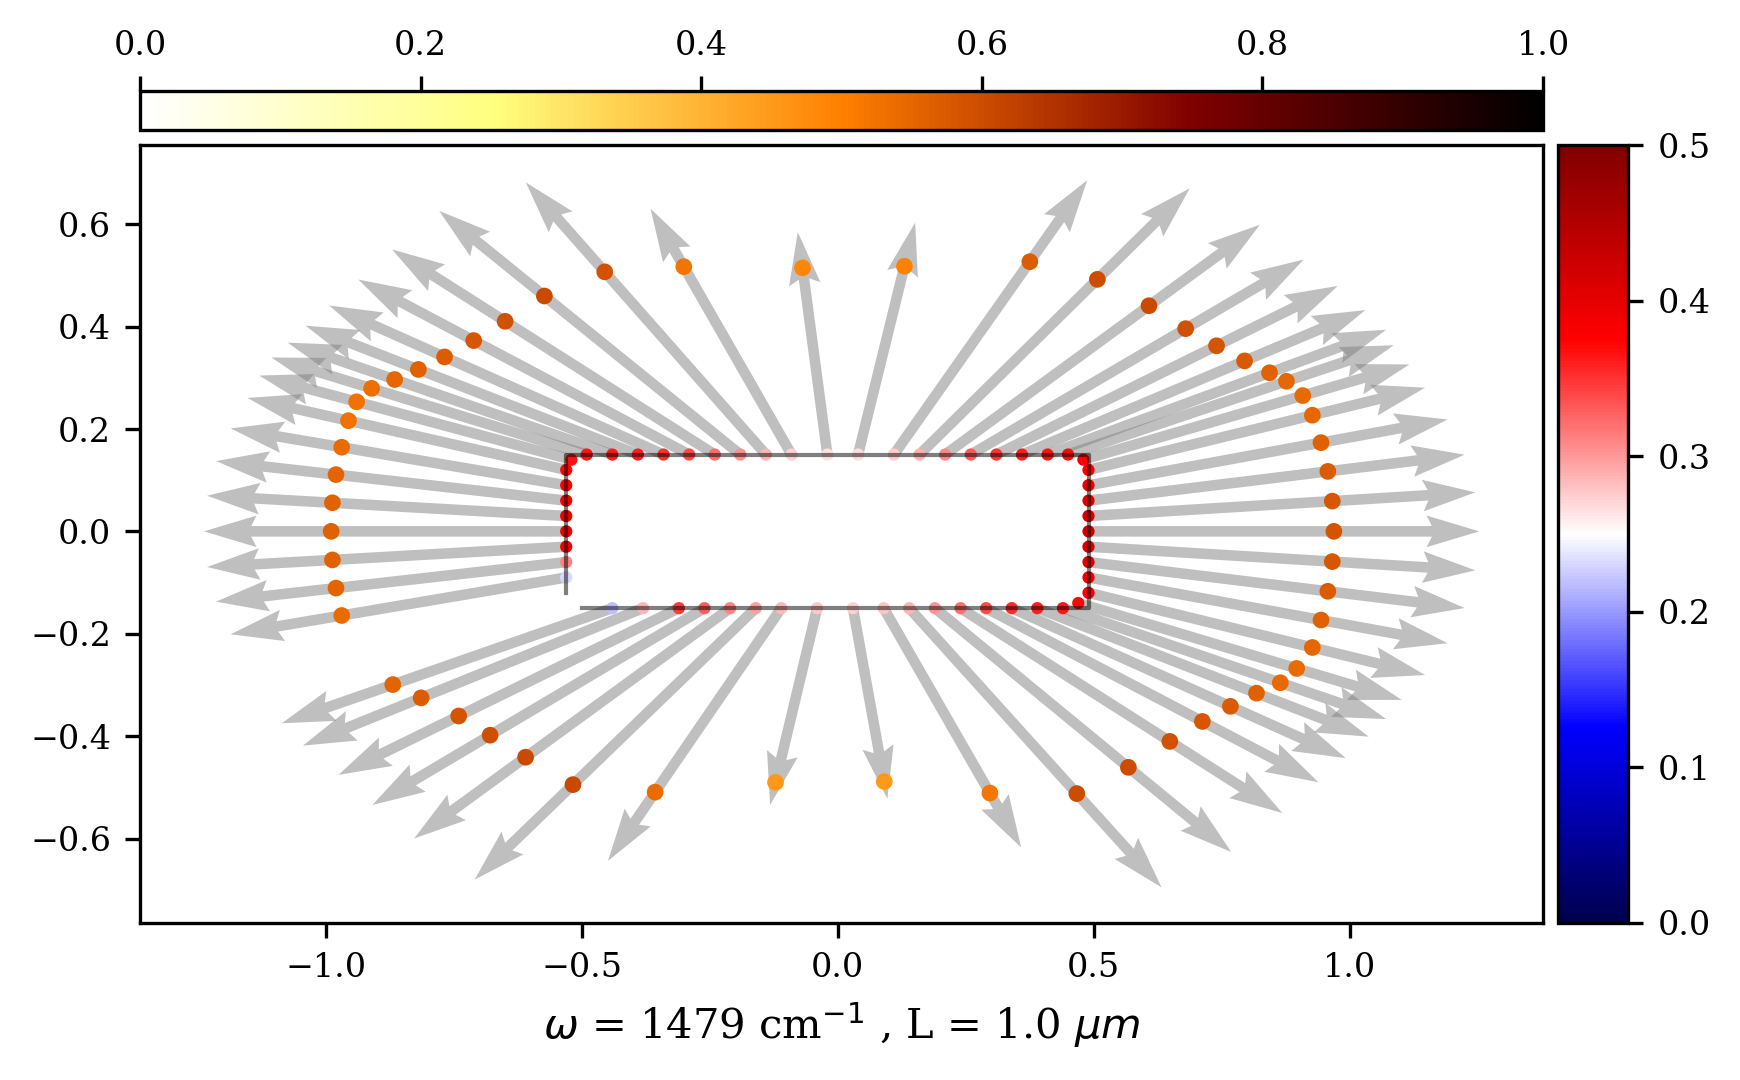

In [54]:
# Constructing and saving image ##################

plot_func5(coordinates,coor_an2,dir_an2,prop_l2,param2,f,f_i,L,p,0,1)
#plt.savefig("Test.png", bbox_inches='tight',dpi=200)
plt.show()

In [55]:
stop

NameError: name 'stop' is not defined

In [56]:
angle_dir2 = []
for i in range((dir_an2.shape[0])):
    angle_dir2.append(angle_(dir_an2[i,:]))
angle_dir2 = np.array(angle_dir2)

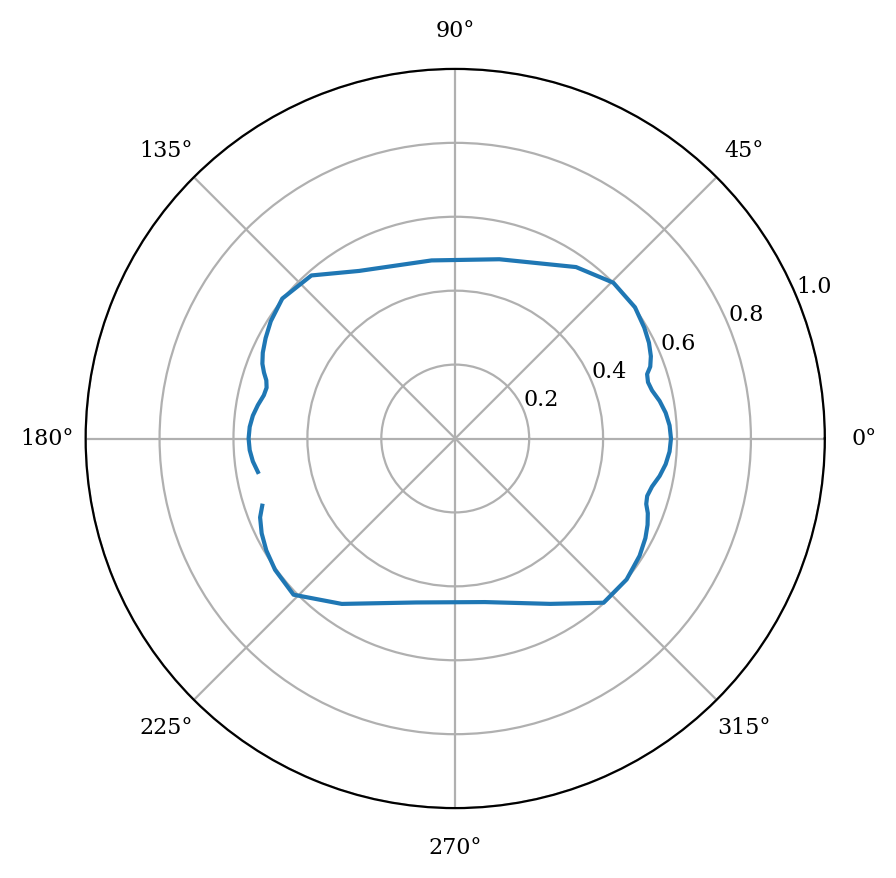

In [57]:
plt.figure()
plt.polar(angle_dir2,param2[:,0])
plt.ylim(0,1)
#plt.savefig("Amp_1480_L1.svg")
plt.show()

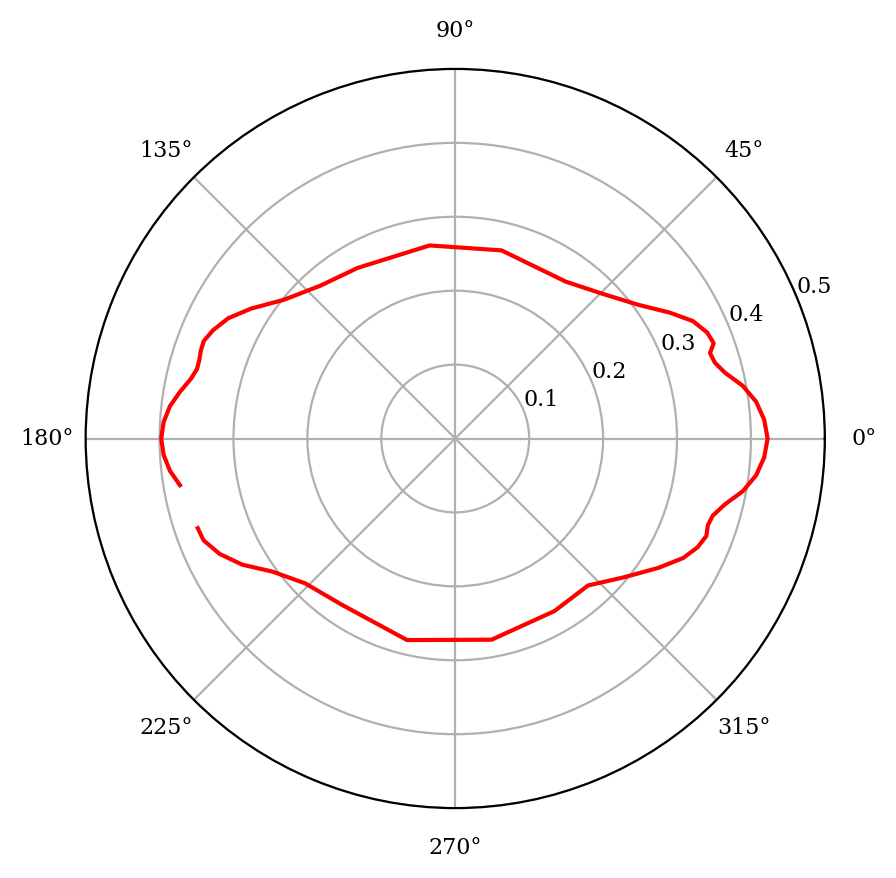

In [58]:
plt.polar(angle_dir2,param2[:,-1],color="red")
plt.ylim(0,0.5)
#plt.savefig("f_1480_L1.svg")
plt.show()

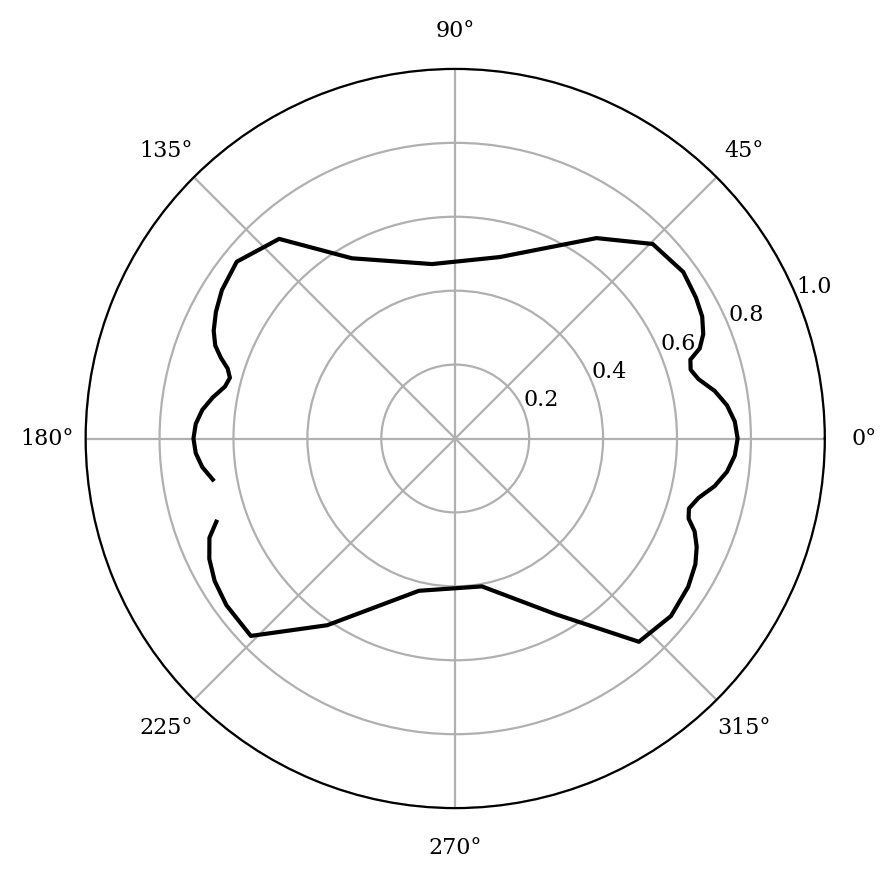

In [61]:
plt.polar(angle_dir2,prop_l2,color="black")
plt.ylim(0,1)
#plt.savefig("DL_1480_L1_v2.svg")
plt.show()